# Image Captioning on the ARMBench Dataset using Autoencoders and Attention

**The Image Captioning is carried out on the ARMBench Dataset here using Autoencoders, Attention and Nearest Neighbours**

The necessary libraries are imported

In [152]:
import pandas as pd #Import necessary libraries
import numpy as np
import json
import os
import cv2
import string
import nltk
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from keras.models import Model
from keras.losses import mean_squared_error
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

In [153]:
from sklearn.utils import resample
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [8]:
from sklearn.utils import resample
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [9]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sahre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preprocessing

In [2]:
import pandas as pd
import os
os.chdir('D:/Down') #Replace the location to where the output.csv file is stored.
df = pd.read_csv('output.csv')


Here, the first 50000 images are used and image paths are added to the dataframe.

In [155]:
import os
import pandas as pd

# Set the base path to the location where the folders of all the ARMBench Dataset images are present
base_path = 'D:/Down/armbench-object-id-0.1/Picks'

def find_one_file(folder_path):
    for root, _, files in os.walk(folder_path):
        if files:  
            return root
    return None


folder_paths = [os.path.join(base_path, folder_name) for folder_name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder_name))]


folder_paths = folder_paths[:50000] #Select first 50000 folder paths


image_paths = [find_one_file(folder_path) for folder_path in folder_paths]


df['image'] = image_paths


The images and captions are preprocessed.

In [156]:
import os
import cv2
from skimage.transform import resize
from skimage.color import gray2rgb

def preprocess_image(image_folder, target_size=(64, 64)): #Resize images to 64x64
    try:
        pick_rgb_file = os.path.join(image_folder, 'PickRGB') #Use pickrgb images
        if os.path.exists(pick_rgb_file):
            image_path = pick_rgb_file
        else:
            image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and
                           f.lower().endswith(('.jpg', '.jpeg', '.png'))] #if Pickrgb not present, any other image file is chosen
            if not image_files:
                raise Exception("No image files found in the folder.")
            image_path = os.path.join(image_folder, image_files[0])

        img = cv2.imread(image_path)
        if img is None:
            raise Exception(f"Failed to read the image at path: {image_path}")

        if len(img.shape) == 2:
            img = gray2rgb(img)

        img_resized = resize(img, target_size, mode='reflect', anti_aliasing=True)
        return img_resized
    except Exception as e:
        print("Error during image preprocessing:", e)
        return None


In [157]:
def preprocess_caption(caption):
    # Lowercase
    caption = caption.lower()
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords and lemmatize
    words = caption.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [158]:
import pandas as pd

unique_categories = df['Dominant_Topic'].unique()
print("Unique Categories")
print(unique_categories)


Unique Categories
[ 6 12  0 13  3  5 14  8 17  9  4 10 16  1 15 11  7  2]


The Dominant Topic value counts are printed for the top 10 categories.

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
df = df.drop_duplicates()

category_freq = df['Dominant_Topic'].value_counts() #Dominant Topic Counts

top_10_categories = category_freq.nlargest(10).index.tolist()

print(category_freq[top_10_categories])

Dominant_Topic
12    6232
13    5381
11    4013
5     3851
3     3789
17    3288
1     3208
4     2982
8     2424
2     2185
Name: count, dtype: int64


2000 Samples are selected from all 10 categories and category distibution is plotted on a bar chart.

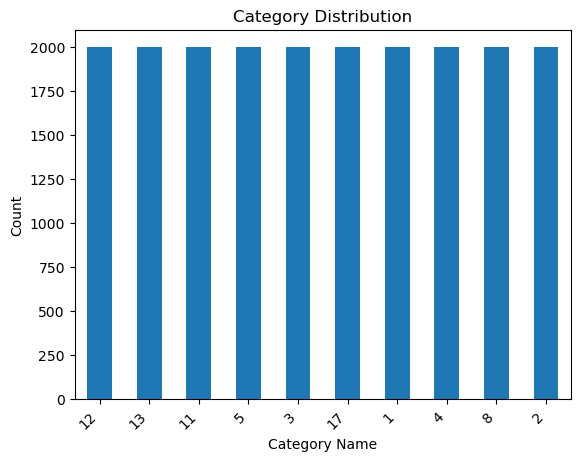

In [160]:

df_ = pd.DataFrame()


for Dominant_Topic in top_10_categories:
    category_data = df[df['Dominant_Topic'] == Dominant_Topic].head(2000)
    df_ = pd.concat([df_, category_data])

df_.reset_index(drop=True, inplace=True)


category_counts = df_['Dominant_Topic'].value_counts() 


category_counts.plot(kind='bar') #Plotting the value counts
plt.title('Category Distribution')
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [161]:
df = df_.copy()

In [162]:
df

,Folder,GT_ID,Container,Tokens,Dominant_Topic,image
0,1001001651777963872,B01N9SPQHQ,La Roche-Posay Toleriane Double Repair Face Mo...,"['la', 'roche-posay', 'tolerian', 'doubl', 're...",12,D:/Down/armbench-object-id-0.1/Picks\001001001...
1,1001001652846741766,1452178593,Press Here,['press'],12,D:/Down/armbench-object-id-0.1/Picks\001001001...
2,1001001653319416098,X002I23L2D,Kids Chewable Iron Supplement (Ferronyl®/Carbo...,"['kid', 'chewabl', 'iron', 'supplement', '(', ...",12,D:/Down/armbench-object-id-0.1/Picks\001001001...
3,1001001653395891055,B0002LCZ6O,"Lysol Disinfectant Wipes, Multi-Surface Antiba...","['lysol', 'disinfect', 'wipe', ',', 'multi-sur...",12,D:/Down/armbench-object-id-0.1/Picks\001001001...
4,1001001653609100556,B07JWX6195,"Affresh Garbage Disposal Cleaner, 9 Tablets (3...","['affresh', 'garbag', 'dispos', 'cleaner', ','...",12,D:/Down/armbench-object-id-0.1/Picks\001001001...
...,...,...,...,...,...,...
19995,3007001657196567230,B07F25KZBB,Amazon Essentials Men's Regular-Fit Short-Slee...,"['amazon', 'essenti', 'men', ""'s"", 'regular-fi...",2,D:/Down/armbench-object-id-0.1/Picks\003007001...
19996,3007001657589752512,X001F4P1A5,BALEAF Men's Polo Shirt Long Sleeve Golf Shirt...,"['baleaf', 'men', ""'s"", 'polo', 'shirt', 'long...",2,D:/Down/armbench-object-id-0.1/Picks\003007001...
19997,3007001658177255427,X0030RVRE9,Woman Square Neck Backless A Line Dress Ruffle...,"['woman', 'squar', 'neck', 'backless', 'line',...",2,D:/Down/armbench-object-id-0.1/Picks\003007001...
19998,3007001659011219774,B004IMY976,Premium Shemagh Head Neck Scarf - Blue/White,"['premium', 'shemagh', 'head', 'neck', 'scarf'...",2,D:/Down/armbench-object-id-0.1/Picks\003007001...


In [163]:
avg_length = df['Container'].apply(len).mean()

In [164]:
avg_length

133.2893

In [165]:
avg_word_count = df['Container'].apply(lambda x: len(x.split())).mean()

In [166]:
avg_word_count

20.8016

After preprocessing the data, the data issplit into training, testing, and validation splits.

In [24]:
from sklearn.model_selection import train_test_split

df_train_temp, df_temp = train_test_split(df, test_size=0.2, random_state=42) #Data splitting

df_validation, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
df_test2 = df_test.copy()
df_validation2 = df_validation.copy()

def preprocess_data(df): #Data preprocessing
    df['image'] = df['image'].apply(preprocess_image)
    df['caption_preprocessed'] = df['Container'].apply(preprocess_caption)
    df = df.dropna(subset=['image'])
    return np.array(df['image'].tolist()), df

x_train, df_train = preprocess_data(df_train_temp)
x_validation, df_validation = preprocess_data(df_validation)
x_test, df_test = preprocess_data(df_test)


## Autoencoder + Attention

The autoencoder architecture (encoder and decoder) along with Attention Mechanism is defined and run for 100 epochs with a batch size of 128

In [28]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Dense, Reshape
from tensorflow.keras.layers import multiply 

input_img = Input(shape=(64, 64, 3)) 

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #encoder architecture
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Spatial attention mechanism
def spatial_attention(input_feature):
    kernel_size = 7 
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    dense = Dense(128, activation='relu')(concat)
    dense = Dense(8, activation='relu')(dense)
    dense = Reshape((1, 1, 8))(dense)

    attention = multiply([input_feature, dense])
    return attention

encoded_with_attention = spatial_attention(encoded)


In [29]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_with_attention) #decoder architecture
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, shuffle=True) #training the model


Epoch 1/100
125/125 [==============================] - 63s 493ms/step - loss: 0.5302
Epoch 2/100
125/125 [==============================] - 64s 516ms/step - loss: 0.4658
Epoch 3/100
125/125 [==============================] - 66s 530ms/step - loss: 0.4603
Epoch 4/100
125/125 [==============================] - 67s 536ms/step - loss: 0.4578
Epoch 5/100
125/125 [==============================] - 68s 548ms/step - loss: 0.4561
Epoch 6/100
125/125 [==============================] - 70s 556ms/step - loss: 0.4548
Epoch 7/100
125/125 [==============================] - 68s 544ms/step - loss: 0.4539
Epoch 8/100
125/125 [==============================] - 68s 540ms/step - loss: 0.4529
Epoch 9/100
125/125 [==============================] - 67s 540ms/step - loss: 0.4519
Epoch 10/100
125/125 [==============================] - 69s 553ms/step - loss: 0.4512
Epoch 11/100
125/125 [==============================] - 71s 564ms/step - loss: 0.4502
Epoch 12/100
125/125 [==============================] - 68s 543

In [30]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_1').output)
x_train_encoded = encoder.predict(x_train) #encoded images
x_test_encoded = encoder.predict(x_test)

63/63 [==============================] - 1s 9ms/step


1/1 [==============================] - 0s 107ms/step


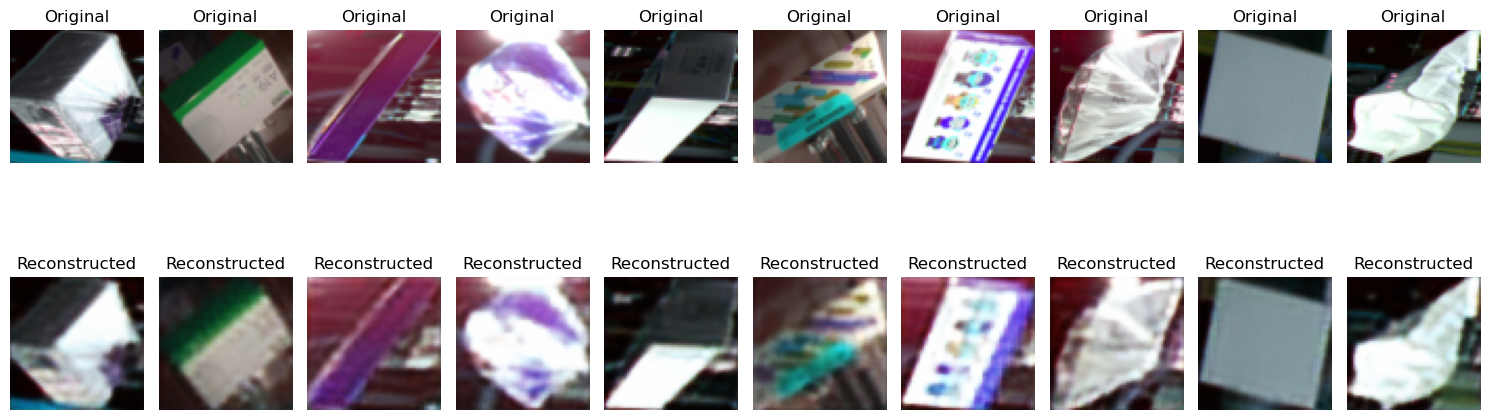

In [31]:
#visualising the original and reconstructed images
num_images_to_visualize = 10
random_indices = np.random.randint(0, len(x_test), num_images_to_visualize)
images_to_visualize = x_test[random_indices]

reconstructed_images = autoencoder.predict(images_to_visualize)

plt.figure(figsize=(15, 6))
for i in range(num_images_to_visualize):
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(images_to_visualize[i])
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(2, num_images_to_visualize, num_images_to_visualize + i + 1)
    plt.imshow(reconstructed_images[i])
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()

The Reconstruction Loss is calculated using the Mean Squared Error Loss.

In [32]:

reconstructed_images = autoencoder.predict(x_test)

# Calculate the Mean Squared Error (MSE) loss
mse_loss = mean_squared_error(x_test, reconstructed_images)

average_mse_loss = np.mean(mse_loss)
print("Average MSE Loss:", average_mse_loss)

63/63 [==============================] - 1s 18ms/step
Average MSE Loss: 0.0023903188


## Nearest Neighbours

The encoded images are flattened and fitted in the Nearest Neighbor Model.

In [33]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


x_train_flat = x_train.reshape(x_train_encoded.shape[0], -1) #fitting the encoded images to Nearest Neighbours

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(x_train_flat)


Here, a random image is visualised and the true and nearest neighbour caption is printed.

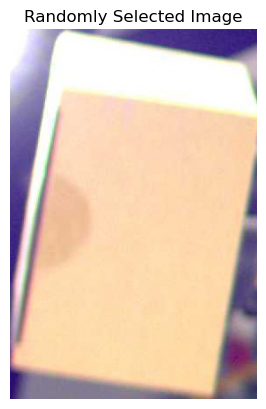

True caption for the randomly selected image: USB Wall Charger, Surge Protector, POWRUI 6-Outlet Extender with 2 USB Charging Ports (2.4A Total) and Night Light, 3-Sided Power Strip with Adapter Spaced Outlets - White，ETL Listed
Generated caption for the randomly selected image: Nieifi Bar Soap Holder for Shower Wall with 4 Hooks, Stainless Steel Adhesive Soap Dish for Bathroom, Silver


In [66]:
import os
from PIL import Image
random_index = np.random.randint(0, len(df_test))
def get_image_path_from_directory(directory): #visualising a randomm image
    pick_rgb_file = os.path.join(directory, 'PickRGB')
    if os.path.exists(pick_rgb_file):
        return pick_rgb_file

    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg'))]
    if image_files:
        return os.path.join(directory, image_files[0])

    return None

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]  # Predicting the caption of the closest neighbor of the image

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

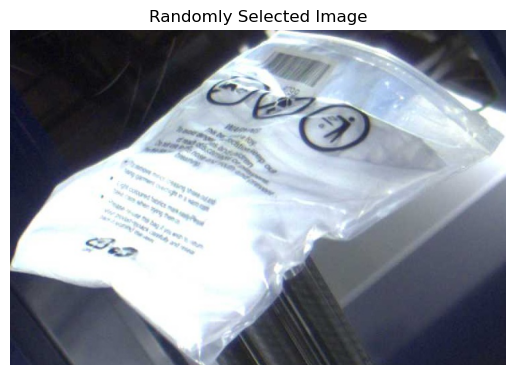

True caption for the randomly selected image: LOVFEE Women's Basic Crop Tops Short Sleeve Tshirts（V-Neck-White/M）
Generated caption for the randomly selected image: 2 Pack Water Swimming Pool Float Hammock,Pool Float Lounger,Water Hammock Lounger, Swimming Floating Bed Hammock,Comfortable Inflatable Swimming Pools Lounger, for Adults Vacation Fun and Rest


In [79]:
import os
from PIL import Image
random_index = np.random.randint(0, len(df_test))
def get_image_path_from_directory(directory):
    pick_rgb_file = os.path.join(directory, 'PickRGB')
    if os.path.exists(pick_rgb_file):
        return pick_rgb_file

    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg'))]
    if image_files:
        return os.path.join(directory, image_files[0])

    return None

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

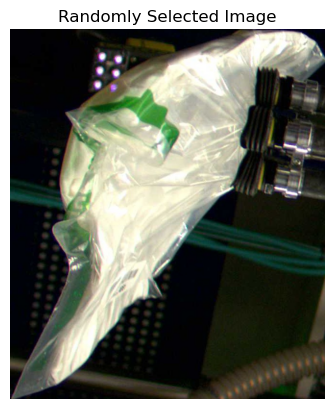

True caption for the randomly selected image: APRAW Mens Summer Henley Shirts Linen 3/4 Sleeves Beach Pullover Tees Loose Yoga Casual Tops
Generated caption for the randomly selected image: Verdusa Women's Loose Drop Shoulder Tree Miami Letter Graphic Oversized Longline Tee Shirt Tops Lilac Purple XL


In [98]:
import os
from PIL import Image
random_index = np.random.randint(0, len(df_test))
def get_image_path_from_directory(directory):
    pick_rgb_file = os.path.join(directory, 'PickRGB')
    if os.path.exists(pick_rgb_file):
        return pick_rgb_file

    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg'))]
    if image_files:
        return os.path.join(directory, image_files[0])

    return None

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

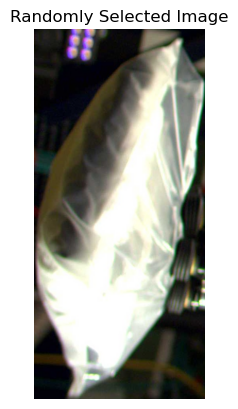

True caption for the randomly selected image: TELALEO Youth Boys' Girls' Thermal Compression Shirt Long Sleeve Fleece Lined Base Layer Athletic Football Undershirt 2 Pack Black/White L
Generated caption for the randomly selected image: CHYRII Women's Cutout Long Sleeve Knitted Ribbed Pullover Sweater Jumper Tops Apricot S


In [101]:
image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

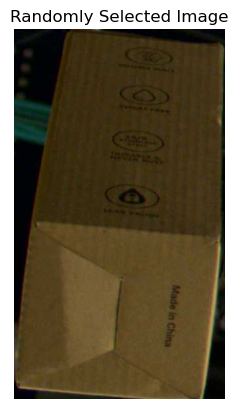

True caption for the randomly selected image: GOPPUS Kids Insulated Water Bottle 12 oz BPA-FREE Double Wall Vacuum Stainless Steel Kids Cup Leakproof Metal Water bottles with Straw & Spout Lid Strap Handle 10pcs Stickers for Toddler Girls Boys School
Generated caption for the randomly selected image: 20 oz Kids Water Bottle with Straw/Chug/Wide Mouth 3 Lids/10 Stickers/Fruit Strainer/Stainless Steel Water Bottles Double Wall Vacuum Insulated One-Click-Open/Carabiner Designed Leakproof for School


In [104]:

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

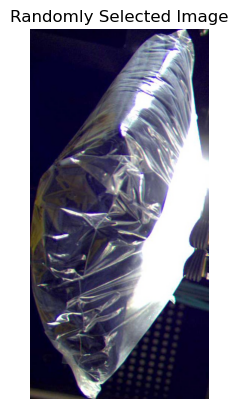

True caption for the randomly selected image: Hanes Men's Essentials Short Sleeve T-shirt Value Pack (4-pack),Navy,X-Large
Generated caption for the randomly selected image: H2H Mens Two-Tone Herringbone Jacket Cardigans Black US L/Asia XL (JLSK03)


In [108]:

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

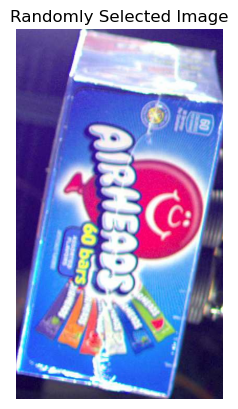

True caption for the randomly selected image: Airheads Candy Bars, Variety Bulk Box, Chewy Full Size Fruit Taffy, Gifts, Halloween, Holiday, Parties, Concessions, Pantry, Non Melting, 60 Individually Wrapped Full Size Bars
Generated caption for the randomly selected image: Remote Control Reversible Sequins Dinosaur Toy for 2 Years Old & Up Girls Boys, RC Dino Can Repeat & Walk & Roar& Sing, Christmas Birthday Gifts for Toddlers Kids


In [110]:

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

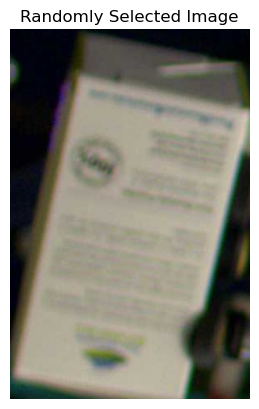

True caption for the randomly selected image: Dandelion Root Capsules - 90 Kosher Vegan caps Now with 450mg Organic Dandelion Root Powder
Generated caption for the randomly selected image: Dreampark Wooden Jigsaw Puzzles, 6 Pack Animal Puzzles for Toddlers Kids 1 2 3 Years Old Educational Toys for Boys and Girls


In [146]:

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

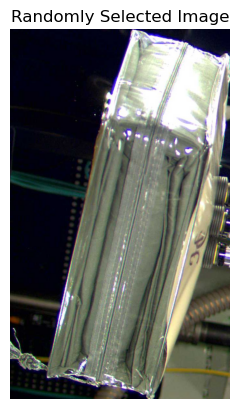

True caption for the randomly selected image: HC Collection King Size Sheets Set - Bedding Sheets & Pillowcases w/ 16 inch Deep Pockets - Fade Resistant & Machine Washable - 4 Piece 1800 Series King Bed Sheet Sets – Gray
Generated caption for the randomly selected image: Visione White Sheets Full, Brushed Microfiber Full Size Egyptian Bedding, Extra Soft Cooling Bed Sheet, Deep Pocket up to 15-inch Mattress, Hypoallergenic Wrinkle, Fade, Shrink Resistant (4 Piece)


In [151]:

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

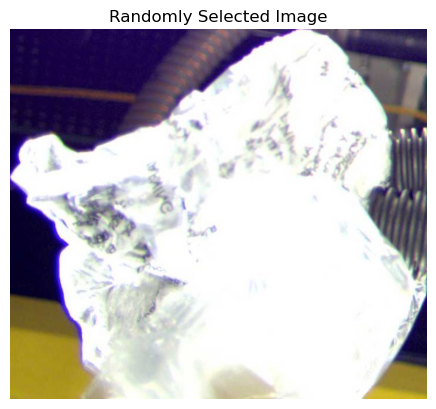

True caption for the randomly selected image: Gildan Youth Toddler T-Shirt, Style G5100P, 2-Pack, Sport Grey, 3T
Generated caption for the randomly selected image: Hely Cancy Kids Tactical Vest Kit with Blaster - Toy Tactical Vest Kit Compatible with Nerf N-Strike Elite Accessory for Boys Girls Blue


In [128]:

image_path = df_test2.iloc[random_index]['image']
chosen_image_path = get_image_path_from_directory(image_path)
if chosen_image_path:
    random_image = Image.open(chosen_image_path)
else:
    print(f"No suitable image found in directory: {image_path}")
random_image = Image.open(chosen_image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off')
plt.show()
random_image = x_test[random_index]

random_image_flat = random_image.reshape(1, -1)

distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['Container'].values


generated_caption = neighbor_captions[0]

true_caption = df_test.iloc[random_index]['Container']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Test Set.

In [37]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_test):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['Container'].values
    true_caption = df_test.iloc[i]['Container']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_test)
average_meteor_score_average = total_meteor_score_average / len(x_test)
average_meteor_score_median = total_meteor_score_median / len(x_test)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")


Average METEOR Score using Closest Neighbor: 0.05279477875654958
Average METEOR Score using Average Distance: 0.04936215083065026
Average METEOR Score using Median Distance: 0.04924084993953677


Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Validation Set.

In [39]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_validation):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['Container'].values
    true_caption = df_validation.iloc[i]['Container']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_validation)
average_meteor_score_average = total_meteor_score_average / len(x_validation)
average_meteor_score_median = total_meteor_score_median / len(x_validation)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")

Average METEOR Score using Closest Neighbor: 0.051773965284093094
Average METEOR Score using Average Distance: 0.04913194977500479
Average METEOR Score using Median Distance: 0.04822449631295824


## Hyperparameter Tuning

Hyperparameter Tuning is carried out to choose the most optimal distance metric.

In [40]:
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

metrics_to_test = ['minkowski', 'manhattan', 'euclidean', 'cosine'] #distance metrics to test


n_neighbors_fixed = 5

best_score = float('inf')
best_metric = None


for metric in metrics_to_test:
    neighbors = NearestNeighbors(n_neighbors=n_neighbors_fixed, metric=metric)
    neighbors.fit(x_train_flat)
    

    distances, _ = neighbors.kneighbors(x_train_flat, n_neighbors=1)
    mean_distance = distances.mean()
    
    if mean_distance < best_score:
        best_score = mean_distance
        best_metric = metric

print("Best metric:", best_metric)

Best metric: manhattan


The encoded images are fitted again using the manhattan distance as the distance metric.

In [41]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


x_train_flat = x_train.reshape(x_train_encoded.shape[0], -1)

neighbors = NearestNeighbors(n_neighbors=5, metric = "manhattan") #fitting the model with the best distance metric
neighbors.fit(x_train_flat)


Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Validation Set with Manhattan Distance as the Distance Metric.

In [43]:
#validation set
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_validation):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['Container'].values
    true_caption = df_validation.iloc[i]['Container']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_validation)
average_meteor_score_average = total_meteor_score_average / len(x_validation)
average_meteor_score_median = total_meteor_score_median / len(x_validation)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")

Average METEOR Score using Closest Neighbor: 0.05457310117849822
Average METEOR Score using Average Distance: 0.05095513698109314
Average METEOR Score using Median Distance: 0.049404483135113704
